In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os, sys
import plotly.graph_objects as go

In [6]:
train = "/content/gdrive/MyDrive/projects/cv _med/DataSet (1)/train"
val = "/content/gdrive/MyDrive/projects/cv _med/DataSet (1)/val"
test = "/content/gdrive/MyDrive/projects/cv _med/DataSet (1)//test"

In [7]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 982 files belonging to 2 classes.
Found 171 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [8]:
# Visualizing data
def visualize_random_images(dataset_type, label_type):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train if dataset_type=="train" else test
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

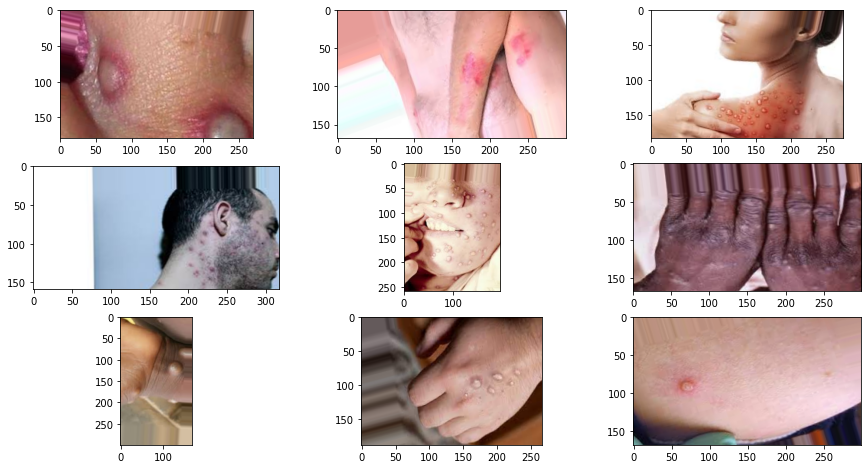

In [9]:
visualize_random_images("train", "mon.pox")

In [10]:
def plot_loss_curves(history):
    
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['f1_score']
  val_accuracy = history.history['val_f1_score']

  epochs = range(len(history.history['loss']))



  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [11]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(num_classes= 1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

In [13]:
from tensorflow import keras
keras_callbacks   = [
    keras.callbacks.EarlyStopping(monitor = 'val_f1_score', patience =4,
                            mode = 'max', verbose = 1,restore_best_weights=True)
]

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[f1])

In [15]:
history = model.fit(train_data,
                       epochs=20,
                       validation_data=val_data,callbacks=[keras_callbacks],shuffle=True)

Epoch 1/20
31/31 [==============================] - 51s 703ms/step - loss: 1.0817 - f1_score: 0.8220 - val_loss: 1.7606 - val_f1_score: 0.6885
Epoch 2/20
31/31 [==============================] - 28s 658ms/step - loss: 0.3300 - f1_score: 0.8512 - val_loss: 0.3995 - val_f1_score: 0.7368
Epoch 3/20
31/31 [==============================] - 29s 710ms/step - loss: 0.0536 - f1_score: 0.8619 - val_loss: 0.6070 - val_f1_score: 0.7568
Epoch 4/20
31/31 [==============================] - 27s 597ms/step - loss: 0.0620 - f1_score: 0.8907 - val_loss: 0.2421 - val_f1_score: 0.8235
Epoch 5/20
31/31 [==============================] - 31s 667ms/step - loss: 0.0529 - f1_score: 0.9119 - val_loss: 0.3717 - val_f1_score: 0.8571
Epoch 6/20
31/31 [==============================] - 28s 592ms/step - loss: 0.0236 - f1_score: 0.9361 - val_loss: 0.5867 - val_f1_score: 0.8571
Epoch 7/20
31/31 [==============================] - 25s 578ms/step - loss: 0.0481 - f1_score: 0.9328 - val_loss: 0.6796 - val_f1_score: 0.8485

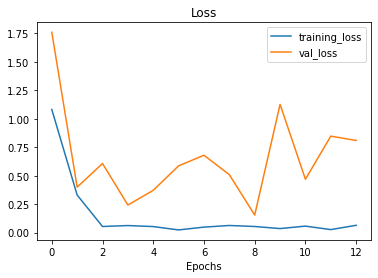

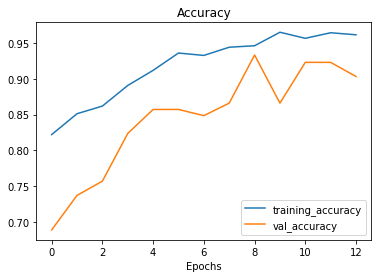

In [16]:
plot_loss_curves(history)

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=epochs,
    y=loss,
    name="Training"       # this sets its legend entry
))


fig.add_trace(go.Scatter(
    x=epochs,
    y=val_loss,
    name="Validation"
))

fig.update_layout(
    title="Model Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    legend_title="Loss vs Epochs",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [24]:
model.evaluate(test_data)

6/6 [==============================] - 2s 393ms/step - loss: 0.5224 - f1_score: 0.9065


[0.5224490165710449, array([0.90654206], dtype=float32)]

In [25]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [27]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

     mon.pox       1.00      0.89      0.94        74
 non-mon.pox       0.92      1.00      0.96        97

    accuracy                           0.95       171
   macro avg       0.96      0.95      0.95       171
weighted avg       0.96      0.95      0.95       171



In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model_1 = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [29]:
for layer in base_model_1.layers:
    layer.trainable = False

In [30]:
base_model_1 = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model_1.trainable = False

for layer in base_model_1.layers:
    layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_1(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model_1 = Model(inputs, outputs)

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[f1])

In [31]:
history_1 = model_1.fit(train_data,
                       epochs=20,
                       validation_data=val_data,callbacks=[keras_callbacks],shuffle=True)

Epoch 1/10
31/31 [==============================] - 34s 711ms/step - loss: 100.9747 - f1_score: 0.7191 - val_loss: 7.6421 - val_f1_score: 0.6726
Epoch 2/10
31/31 [==============================] - 26s 592ms/step - loss: 31.9153 - f1_score: 0.7386 - val_loss: 12.2776 - val_f1_score: 0.6885
Epoch 3/10
31/31 [==============================] - 24s 554ms/step - loss: 7.0850 - f1_score: 0.7917 - val_loss: 1.1111 - val_f1_score: 0.6885
Epoch 4/10
31/31 [==============================] - 25s 559ms/step - loss: 0.9241 - f1_score: 0.7980 - val_loss: 0.6574 - val_f1_score: 0.6885
Epoch 5/10
31/31 [==============================] - 26s 621ms/step - loss: 0.6459 - f1_score: 0.7980 - val_loss: 0.6714 - val_f1_score: 0.6885
Epoch 6/10
31/31 [==============================] - 25s 581ms/step - loss: 0.6280 - f1_score: 0.7980 - val_loss: 0.6805 - val_f1_score: 0.6885
Epoch 6: early stopping


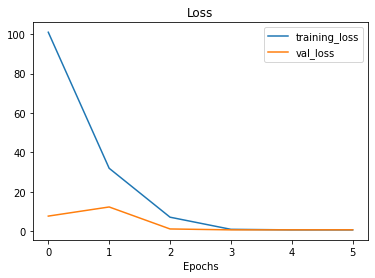

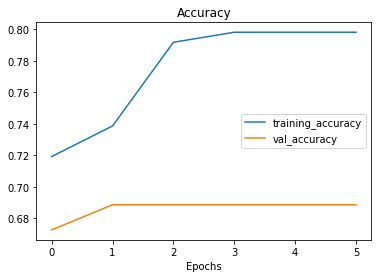

In [32]:
plot_loss_curves(history_1)

In [33]:
model_1.evaluate(test_data)

6/6 [==============================] - 2s 433ms/step - loss: 9.6896 - f1_score: 0.7239


[9.689590454101562, array([0.7238806], dtype=float32)]

In [34]:
y_pred_1 = tf.math.round(model_1.predict(test_data))
y_true_1 = []
for images, labels in test_data.unbatch():
  y_true_1.append(labels.numpy())

In [35]:
accuracy_score(y_true_1, y_pred_1)

0.5906432748538012

In [36]:
print(classification_report(y_true_1, y_pred_1, target_names=train_data.class_names))

              precision    recall  f1-score   support

     mon.pox       0.57      0.23      0.33        74
 non-mon.pox       0.60      0.87      0.71        97

    accuracy                           0.59       171
   macro avg       0.58      0.55      0.52       171
weighted avg       0.58      0.59      0.54       171



In [37]:
from tensorflow.keras.applications import ResNet50

base_model_2 = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [38]:
base_model_2.trainable = False

for layer in base_model_2.layers:
    layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_2(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model_2 = Model(inputs, outputs)

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[f1])

In [39]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[f1])

In [40]:
history_2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,callbacks=[keras_callbacks],shuffle=True)

Epoch 1/10
31/31 [==============================] - 31s 636ms/step - loss: 4.9444 - f1_score: 0.8053 - val_loss: 0.8512 - val_f1_score: 0.7568
Epoch 2/10
31/31 [==============================] - 27s 643ms/step - loss: 0.9154 - f1_score: 0.8587 - val_loss: 0.9528 - val_f1_score: 0.7778
Epoch 3/10
31/31 [==============================] - 25s 565ms/step - loss: 0.3460 - f1_score: 0.8893 - val_loss: 0.3689 - val_f1_score: 0.8235
Epoch 4/10
31/31 [==============================] - 24s 559ms/step - loss: 0.2105 - f1_score: 0.9030 - val_loss: 0.4321 - val_f1_score: 0.8155
Epoch 5/10
31/31 [==============================] - 25s 566ms/step - loss: 0.1532 - f1_score: 0.9196 - val_loss: 0.5364 - val_f1_score: 0.8571
Epoch 6/10
31/31 [==============================] - 25s 569ms/step - loss: 0.0720 - f1_score: 0.9164 - val_loss: 0.4169 - val_f1_score: 0.8000
Epoch 7/10
31/31 [==============================] - 25s 561ms/step - loss: 0.1210 - f1_score: 0.9125 - val_loss: 0.2778 - val_f1_score: 0.7925

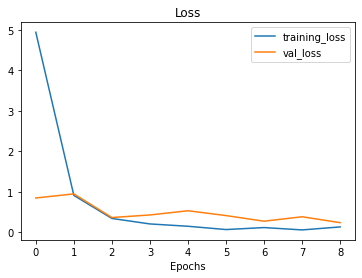

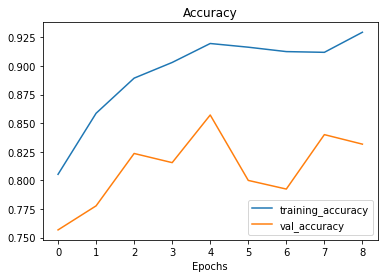

In [41]:
plot_loss_curves(history_2)

In [42]:
model_2.evaluate(test_data)

6/6 [==============================] - 2s 325ms/step - loss: 1.0738 - f1_score: 0.8472


[1.0737628936767578, array([0.8471616], dtype=float32)]

In [43]:
y_pred_2 = tf.math.round(model_2.predict(test_data))
y_true_2 = []
for images, labels in test_data.unbatch():
  y_true_2.append(labels.numpy())

In [44]:
accuracy_score(y_true_2, y_pred_2)

0.8771929824561403

In [45]:
print(classification_report(y_true_2, y_pred_2, target_names=train_data.class_names))

              precision    recall  f1-score   support

     mon.pox       0.87      0.84      0.86        74
 non-mon.pox       0.88      0.91      0.89        97

    accuracy                           0.88       171
   macro avg       0.88      0.87      0.87       171
weighted avg       0.88      0.88      0.88       171

